# HW5 Kaggle Competition

@Author: Jordon Young (joyo8856)

To start, let's get one thing straight--my goal was not to get the most accurate model here. My goal was to explore how these tools work and intentionally make a less complicated, less computationally intensive model and solution to this problem.

I like to do development locally and don't like to wait for models to train overnight. Focusing on efficiency for this assignment has allowed me to more rapidly iterate on my model and experiment with different strategies.

### What is the problem? Histopathologic Cancer Detection.

This Kaggle competition comes with about 6GB of training images from digital pathology scans. Each image is only 96x96 pixels, so that is a lot of entries. The data is divided into training and testing data already. My task is to make a model that classifies images as either cancer or not cancer.


## Load and Preprocess Data

The data provided is included as 96x96 pixel images, but reading the competition description, only the center 32x32 pixels are considered. In other words, is there cancer present in the center of the image? Cropping the images to focus on the center only was a convenient step to reduce the computation time--both on loading and training the model.

Another benefit of this cropping, I hypothesize, is that this allows my model to learn only on the part of the image that will be evaluated on as opposed to identifying patterns in the outside portions of the image which may not be relevant to "identifying cancer in the center of the image".

I normalized the RGB values, but that's not really to save space. I also included a `fraction` variable to randomly select a portion of the training data only. The selection happens with the IDs, so only the necessary images are loaded into memory. Using `0.1` as the `fraction`, I was able to load all the images in one minute.


In [3]:
# Check if TensorFlow is installed and if GPU is available

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.1
GPU available: []


In [4]:
# Load Data

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Load the labels
train_labels = pd.read_csv('data/train_labels.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# The images sizes are 96x96 despite the competition focus on the center 32x32 pixels
IMAGE_SIZE = (96, 96)
CROP_SIZE = (32, 32)

# Crop an image and return only the center 32x32 pixels
def crop_center(image, crop_size=CROP_SIZE):
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    half_crop_size_x, half_crop_size_y = crop_size[1] // 2, crop_size[0] // 2
    return image[center_y - half_crop_size_y:center_y + half_crop_size_y,
                 center_x - half_crop_size_x:center_x + half_crop_size_x, :]

# Load, crop, and normalize the images
def load_image(image_path, crop=False):
    image = load_img(image_path, target_size=IMAGE_SIZE)
    image = img_to_array(image)
    if crop:
        image = crop_center(image)
    image = image / 255.0
    return image

def load_images(image_ids, image_dir, crop=False):
    image_paths = [os.path.join(image_dir, f'{image_id}.tif') for image_id in image_ids]
    images = [load_image(image_path, crop) for image_path in image_paths]
    return np.array(images)

# Load the images and labels
image_ids = train_labels['id'].values
labels = train_labels['label'].values

# Split the data into training and validation sets
train_ids, val_ids, train_labels, val_labels = train_test_split(image_ids, labels, test_size=0.2, random_state=42)

# Define a fraction of the dataset to use for testing
fraction = 0.1  # Use 0.1 for quick testing

# Sample the training and validation IDs
train_sample_ids = np.random.choice(train_ids, size=int(len(train_ids) * fraction), replace=False)
val_sample_ids = np.random.choice(val_ids, size=int(len(val_ids) * fraction), replace=False)

# Load the training and validation images with cropping
train_images = load_images(train_sample_ids, 'data/train', crop=True)
val_images = load_images(val_sample_ids, 'data/train', crop=True)

# Convert labels to numpy arrays
train_labels = np.array([labels[image_ids.tolist().index(id)] for id in train_sample_ids])
val_labels = np.array([labels[image_ids.tolist().index(id)] for id in val_sample_ids])

# Check data shapes and types
print(f"train_images shape: {train_images.shape}, dtype: {train_images.dtype}")
print(f"train_labels shape: {train_labels.shape}, dtype: {train_labels.dtype}")
print(f"val_images shape: {val_images.shape}, dtype: {val_images.dtype}")
print(f"val_labels shape: {val_labels.shape}, dtype: {val_labels.dtype}")

# Check for NaNs in the data
print(f"NaNs in train_images: {np.isnan(train_images).sum()}")
print(f"NaNs in train_labels: {np.isnan(train_labels).sum()}")
print(f"NaNs in val_images: {np.isnan(val_images).sum()}")
print(f"NaNs in val_labels: {np.isnan(val_labels).sum()}")

train_images shape: (17602, 32, 32, 3), dtype: float32
train_labels shape: (17602,), dtype: int64
val_images shape: (4400, 32, 32, 3), dtype: float32
val_labels shape: (4400,), dtype: int64
NaNs in train_images: 0
NaNs in train_labels: 0
NaNs in val_images: 0
NaNs in val_labels: 0


In [5]:
# Load Plot Function

import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from the history object.

    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
    """
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks(range(len(history.history['accuracy'])))  # Set x-ticks to be integers

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks(range(len(history.history['loss'])))  # Set x-ticks to be integers

    plt.show()

## Build and Train Model

In building the model, I tried not to use too many layers because each layer is additional computation. The main layers in my model attempt to make use of the RGB information first, then pool by half the amount of data, flatten, drop some of the data to prevent over-fitting, then look for more complex, dense patterns.

I included early stopping so if after a specified number of epics there is no improvement in the monitored metric, it stops training. I try to also select the best model based on the validation accuracy and loss.

The longer I went on playing with this project, the more I wanted to improve the models accuracy. You'll see I added more to the model, trying to capture information by performing convolutions of different sizes since the sample images tend to have blobs of different sizes. I also increased the patience, lowered the min_delta, and increased the maximum number of epoch to let the model over train itself. The early stopping class and best model selection should select the best one. Sometimes the accuracy goes down for a few epochs before increasing again, so it's worth seeing what happens.

After the training section, there are two graphs which show the model accuracy and loss for training and validation.

These are the configurations I used for submission. In the code blocks below, I used the same cropped image size and training data for all models just to show 1 for 1 comparison.

| Model # | Image Size | Training Data Proportion | Kaggle Accuracy\*\* |
| :-----: | :--------: | :----------------------: | :-----------------: |
|    1    |   32x32    |           0.1            |       0.7652        |
|    2    |   32x32    |           0.1            |       0.7853        |
|   3\*   |   96x96    |           0.1            |       0.8472        |
|    3    |   96x96    |            1             |       0.8266        |
|    3    |   32x32    |            1             |         0.          |

\*Model 3 was trained with uncropped images (96x96), where models 1 and 2 were trained on center cropped images (32x32).

\*\*I also don't remember if I trained my model on the full data set for submissions 1 and 2. I don't think I did.


Epoch 1/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6637 - loss: 0.6112 - val_accuracy: 0.7225 - val_loss: 0.5490
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7379 - loss: 0.5448 - val_accuracy: 0.7561 - val_loss: 0.5510
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7634 - loss: 0.5254 - val_accuracy: 0.7373 - val_loss: 0.5413
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7531 - loss: 0.5243 - val_accuracy: 0.7552 - val_loss: 0.5178
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7658 - loss: 0.5184 - val_accuracy: 0.7675 - val_loss: 0.4998
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7618 - loss: 0.5048 - val_accuracy: 0.7677 - val_loss: 0.4971
Epoch 7/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7787 - loss: 0.4897 - val_accuracy: 0.7714 - val_loss: 0.4933
Epoch 8/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7846 - loss: 0.4826 - val_accuracy: 0.

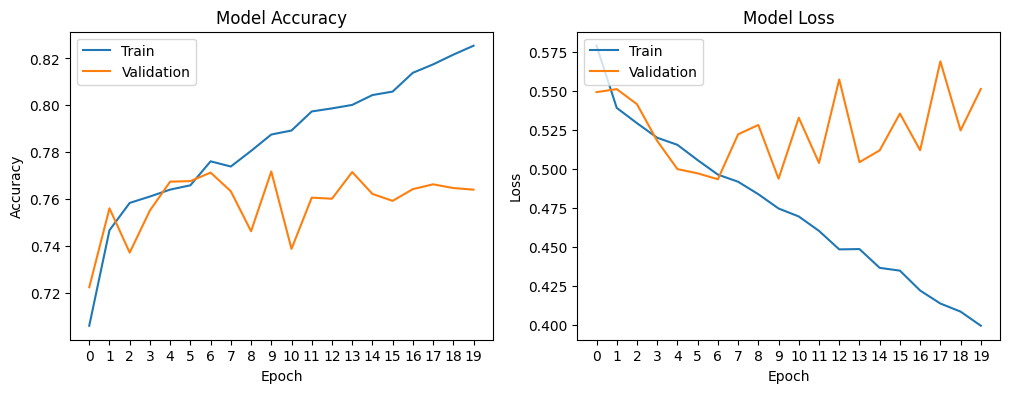

In [6]:
# Model 1

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define a simple model
model1 = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with verbose output
history1 = model1.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), verbose=1)

plot_training_history(history1)

Epoch 1/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7165 - loss: 0.5565 - val_accuracy: 0.7155 - val_loss: 0.5665
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7873 - loss: 0.4761 - val_accuracy: 0.6386 - val_loss: 0.7236
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7909 - loss: 0.4667 - val_accuracy: 0.7673 - val_loss: 0.4799
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7973 - loss: 0.4666 - val_accuracy: 0.7855 - val_loss: 0.4896
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7958 - loss: 0.4596 - val_accuracy: 0.7936 - val_loss: 0.4496
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7923 - loss: 0.4635 - val_accuracy: 0.7341 - val_loss: 0.5591
Epoch 7/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7972 - loss: 0.4548 - val_accuracy: 0.8011 - val_loss: 0.4356
Epoch 8/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8005 - loss: 0.4473 - val_accu

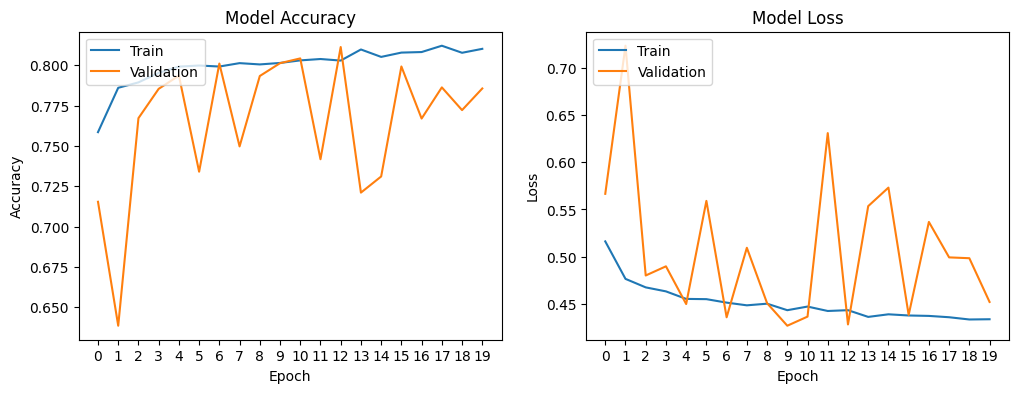

In [7]:
# Model 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D

# Define a simple model
model2 = Sequential([    
    Input(shape=(32, 32, 3)),

    Conv2D(4, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    GlobalAveragePooling2D(),
    
    Dense(32, activation='relu'),
    Dropout(0.33),
    
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with verbose output
history2 = model2.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), verbose=1)

plot_training_history(history2)

Epoch 1/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6833 - loss: 0.6139 - val_accuracy: 0.7727 - val_loss: 0.4978
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7617 - loss: 0.5106 - val_accuracy: 0.7780 - val_loss: 0.4762
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7791 - loss: 0.4840 - val_accuracy: 0.7661 - val_loss: 0.4835
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7868 - loss: 0.4752 - val_accuracy: 0.7959 - val_loss: 0.4533
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7918 - loss: 0.4680 - val_accuracy: 0.7127 - val_loss: 0.5836
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7935 - loss: 0.4607 - val_accuracy: 0.7884 - val_loss: 0.4605
Epoch 7/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7883 - loss: 0.4617 - val_accuracy: 0.7802 - val_loss: 0.4732
Epoch 8/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7953 - loss: 0.4541 - val_accuracy: 0.

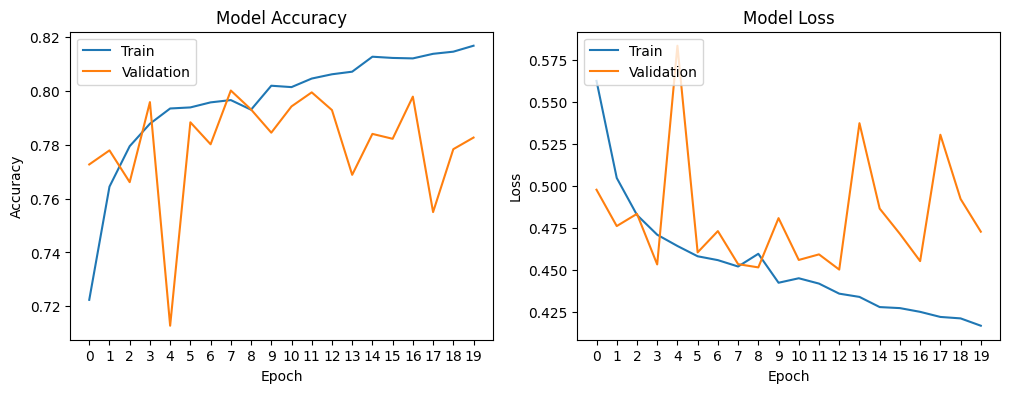

In [8]:
# Model 3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D

# Define a simple model
model3 = Sequential([    
    Input(shape=(32, 32, 3)),
    
    Conv2D(4, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    
    Dense(32, activation='relu'),
    Dropout(0.33),
    
    Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with verbose output
history3 = model3.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), verbose=1)

plot_training_history(history3)

## Evaluate Model


In [9]:
# Choose Model for Evaluation/Submission
model = model3

In [10]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Loss: {val_loss}')

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7677 - loss: 0.4984
Validation Accuracy: 0.7827273011207581
Validation Loss: 0.4728482961654663


## Make Predictions


In [11]:
# Create Submission File

# Load the test images
test_ids = sample_submission['id'].values
test_images = load_images(test_ids, 'data/test', crop=True)

# Make predictions
predictions = model.predict(test_images)
predictions = (predictions > 0.5).astype(int).flatten()

# Prepare the submission file
submission = pd.DataFrame({'id': test_ids, 'label': predictions})
submission.to_csv('submission.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


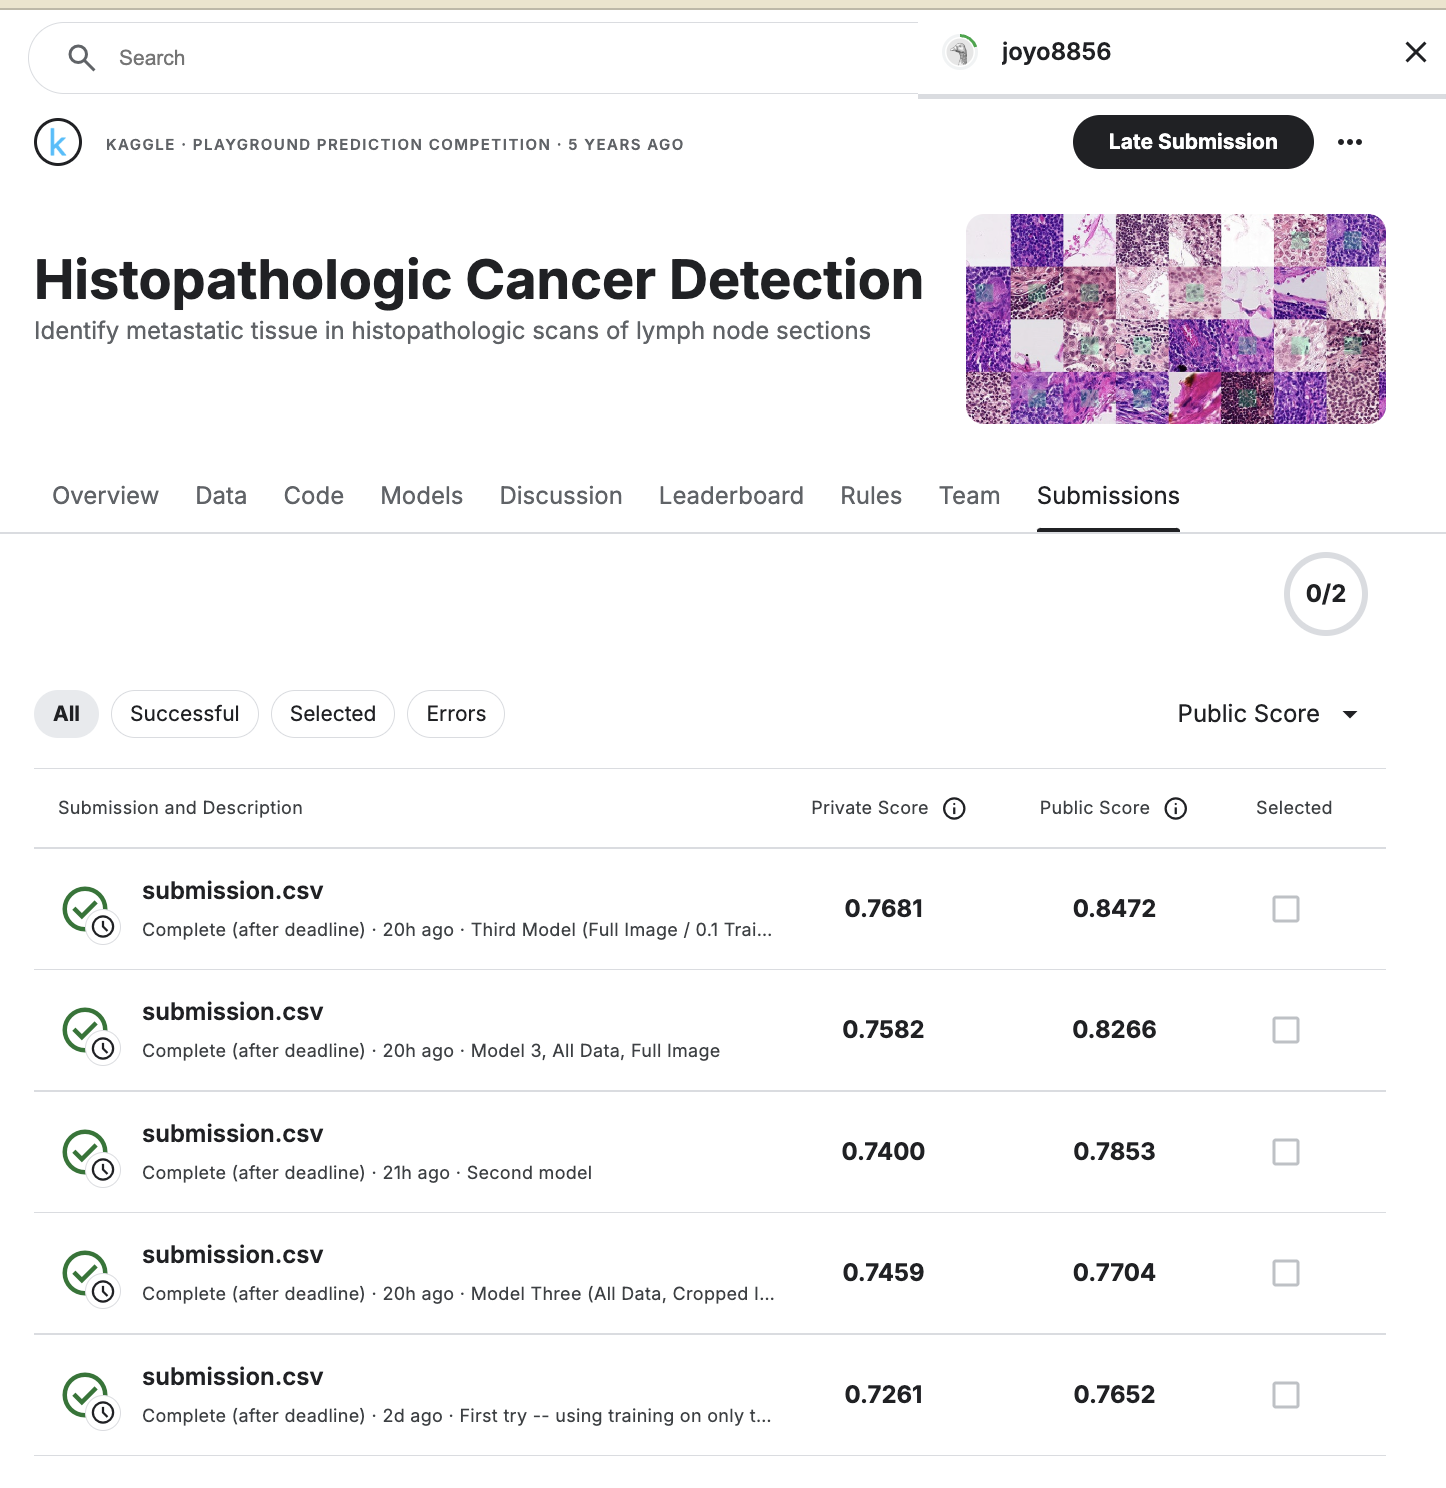


## Conclusion
